# $\mathrm{n-C_3H_7CHO}$

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

predict_logσ_wΔ

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "n-C3H7CHO" 
nice_name = "n-C₃H₇CHO"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

([187.0, 197.0, 215.0, 238.0, 253.7, 265.4, 280.4, 313.0, 265.2, 280.4  …  350.896, 350.964, 351.033, 351.101, 351.17, 351.238, 351.307, 351.375, 351.444, 351.513], [7.1e-20, 1.8e-20, 8.5e-21, 7.8e-21, 1.4e-20, 2.6e-20, 3.4e-20, 3.1e-20, 2.77e-20, 4.87e-20  …  -2.21146e-22, -2.52851e-22, -2.45467e-22, -3.9421e-22, -2.75088e-22, -3.03909e-22, -3.49437e-22, -3.36085e-22, -3.96982e-22, -4.4531e-22], [298.0, 305.0, 293.0, 323.0, 298.0, 298.0, 298.0, 300.0, 298.0, 298.0, 298.0, 298.0, 298.0, 298.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  14, 14, 14, 14, 14, 14, 14, 14, 14, 14], "K", "Organics (carbonyls)", "n-C3H7CHO", "nm", "cm^2")

In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

2706


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,277.825,144.39,281.629,365.0,0,Float64
2,σ,6.17016e-19,6.25754e-24,1.96553e-20,2.83e-17,0,Float64
3,T,298.071,293.0,298.0,305.0,0,Float64
4,source_id,11.2136,1,13.0,14,0,Int64


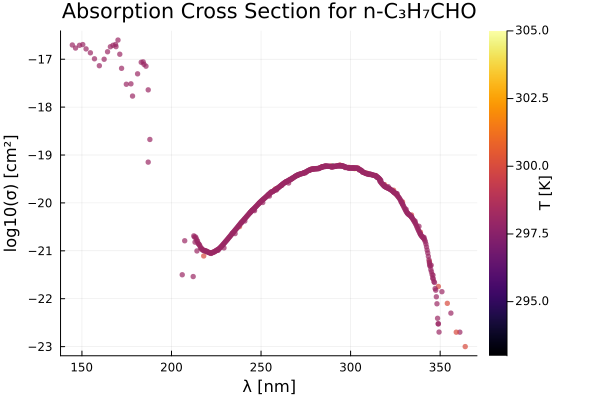

In [8]:
nskip = 5

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)


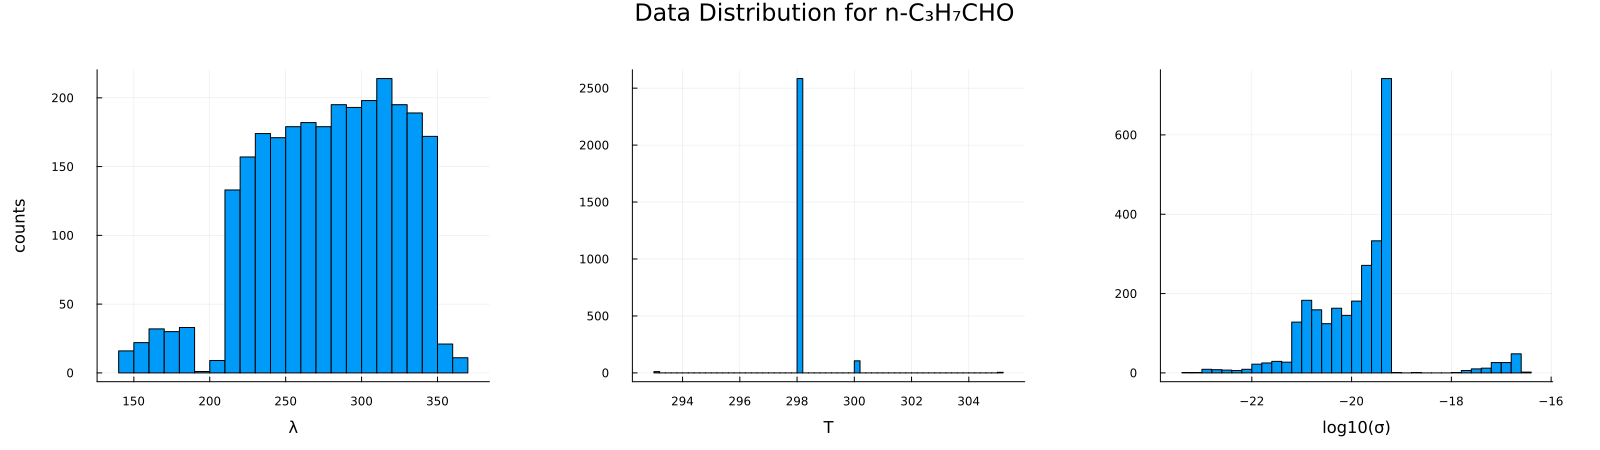

In [9]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [10]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [11]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [12]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,280.0,4.96e-20,293.0
2,285.0,5.85e-20,293.0
3,290.0,5.88e-20,293.0
4,295.0,6.14e-20,293.0
5,300.0,5.82e-20,293.0
6,305.0,5.68e-20,293.0
7,310.0,4.17e-20,293.0
8,315.0,3.38e-20,293.0
9,320.0,2.28e-20,293.0


In [43]:
#function representative_rand_sample(column::AbstractVector, nbins::Int, npoints::Int)
#    n_per_bin = floor(Int, npoints/nbins)
#    hist = fit(Histogram, column, nbins=nbins)
#    bin_edges = hist.edges[1]
#    
#    idx_out = []
#    
#    # loop over each bin
#    for i ∈ 1:size(bin_edges, 1)-1
#        bin_idxs = findall(ξ -> bin_edges[i] < ξ && ξ < bin_edges[i+1], column)
#        n_to_sample = minimum([n_per_bin, size(bin_idxs, 1)])
#        idx_res = sample(bin_idxs, n_to_sample, replace=false)
#        push!(idx_out, idx_res)  # sample without replacement
#    end
#
#    return unique(vcat(idx_out...))
#end
#
#λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
#σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 
#
#idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))

#
#df_sampled = df_unique[idxs_res, :]
df_sampled = df_unique[df_unique.T .> 294.0, :]

println(size(df_sampled))

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

(2576, 3)


144.39

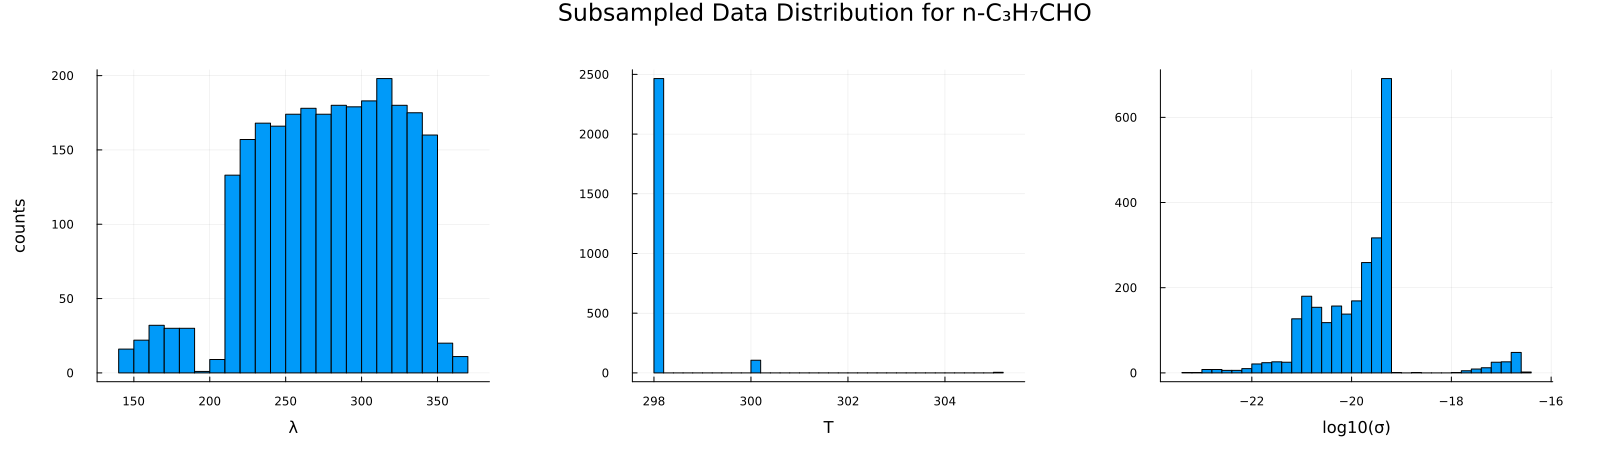

In [44]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

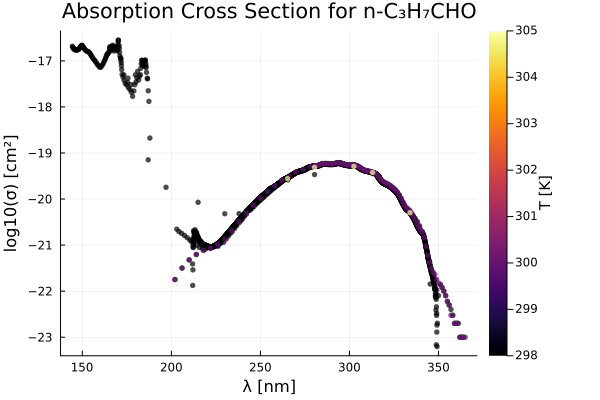

In [45]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [51]:
train_frac = 0.8
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

2060


In [52]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

516-element Vector{Float64}:
 -19.234660829398965
 -20.226615134010366
 -19.526889825195763
 -20.87879482670351
 -20.678606649677597
 -20.534175642015576
 -22.17773643866748
 -20.003996469356462
 -19.3904258654376
 -19.427478064299315
 -19.607653084940246
 -19.50465828797167
 -19.21978425118065
   ⋮
 -19.27123646981388
 -19.29017056681349
 -19.229533872129107
 -19.231731983548453
 -19.276820262384117
 -20.03102932784853
 -19.28978275017884
 -21.10790539730952
 -20.78806291987256
 -19.786354762418085
 -23.0
 -20.147158448160003

In [80]:
# compute length scales
#κ = 10
#ℓ_λ = std(Xtrain.λ)/κ
ℓ_λ = 5.0
#ℓ_T = std(Xtrain.T)/κ
ℓ_T = 5.0

# compute variance parameters
# SNR = 500
σf² = 50*var(ytrain)
println(σf²)
#σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

48.49711672655871


mykernel (generic function with 1 method)

In [81]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=20.0,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(3.8815043469320867, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(1.6094379094538682, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(1.6094379094538682, exp, 1.4901161193847656e-8)), 
  σ² = 20.0, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [82]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0     5.095416e+03     9.998429e+02
 * time: 0.00015115737915039062
     1    -2.056001e+03     3.762518e+02
 * time: 11.348880052566528
     2    -2.204787e+03     5.455314e+02
 * time: 14.425292015075684
     3    -2.280443e+03     4.161550e+02
 * time: 16.64633297920227
     4    -2.378137e+03     1.460660e+02
 * time: 18.68384599685669
     5    -2.390248e+03     4.914234e+01
 * time: 20.995479106903076
     6    -2.395869e+03     1.396746e+02
 * time: 24.070801973342896
     7    -2.463945e+03     6.127488e+01
 * time: 28.25985312461853
     8    -2.472870e+03     3.131005e+01
 * time: 31.25328302383423
     9    -2.474782e+03     2.698095e+01
 * time: 34.495376110076904
    10    -2.475727e+03     1.165033e+01
 * time: 37.543434143066406
    11    -2.475781e+03     8.533792e-01
 * time: 40.6369411945343
    12    -2.475782e+03     1.436338e-02
 * time: 43.88439702987671
    13    -2.475782e+03     2.538440e-04
 * time: 46.827174186706

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @104 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @292 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [90]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [3.8770750710882287, 1.2874108345254445, 4.6449803377068735, -5.730612539518701],
 minimum = -2475.78165924109,
 iterations = 980,
 converged = false,)

In [91]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


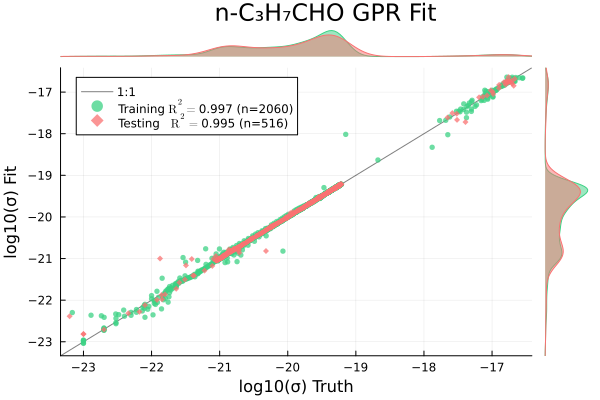

In [92]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


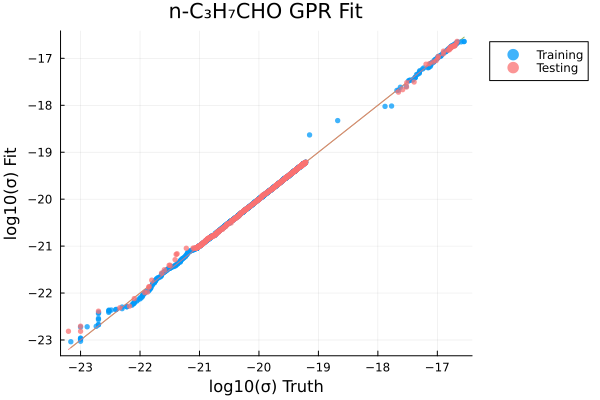

In [93]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


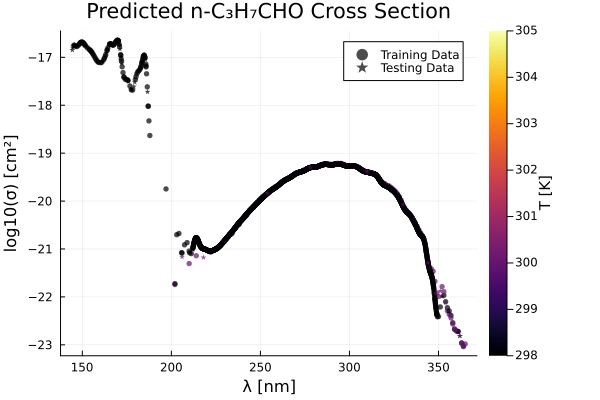

In [94]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

194.249
365.0


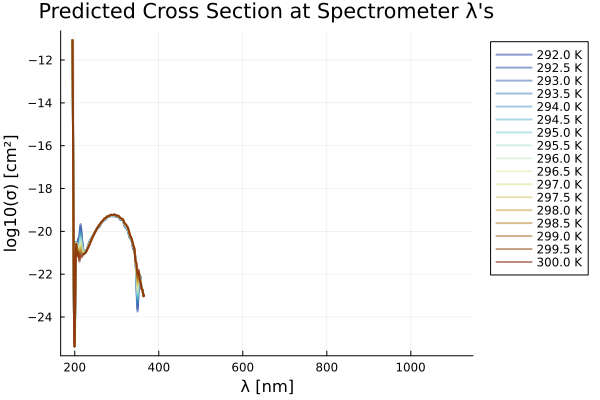

In [95]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

function predict_logσ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = predict_mean(mach, Xout)
    
    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    res[idxs] .= NaN 
    return res
end



p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

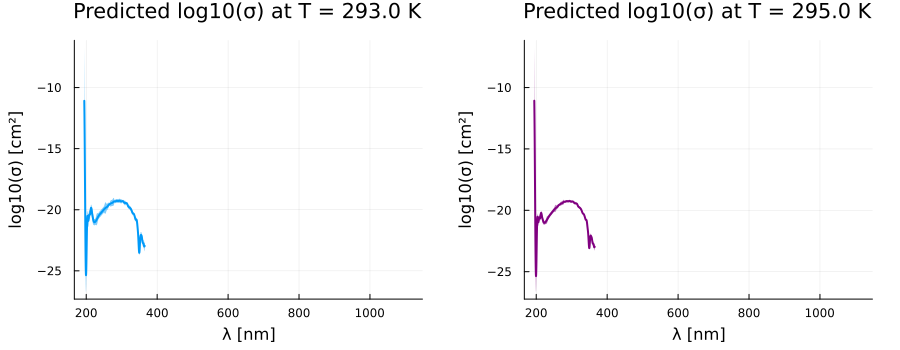

In [96]:
function predict_logσ_wΔ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = MLJ.predict(mach, Xout)

    logσ = mean.(res)
    Δlogσ = std.(res)

    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    logσ[idxs] .= NaN 
    Δlogσ[idxs] .= NaN 
    return logσ, Δlogσ
    #return res
end

Tplot = 293.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 295.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 